# Homework 6: Emilie Engen, 100356077

# Machine Learning

## Homework #6: Hidden Markov Models for speech processing

### A. The three Basic Problems for HMMs

For convenience, we use the compact notation 

$$\lambda=(A, B,  \pi)$$

to indicate the complete parameter set of the model, where $A$ is the state transition probability distribution, $B$ the emission probability distribution (which can be any distribution with parameters $\Theta$) and $\pi$ the initial state distribution.

### Problem 1: 
Given the observation sequence $O=O_1, O_2, ..., O_T$, and a model $\lambda=(A, B,  \pi)$, how do efficiently compute $P(O|\lambda)$?
Problem 1 is the evaluation problem, namely given a model and a sequence of observations, how do we compute the probability that the observed sequence was produced by the model. To solve this problem we use the **forward-backward algorithm**.

### Problem 2: 
Given the observation sequence $O=O_1, O_2, ..., O_T$, and a model $\lambda=(A, B,  \pi)$, how do we choose a corresponding state sequence $Q= q_1, q_2, ..., q_T$?
Problem 2 is the one in which we attempt to uncover the hidden part of the model, that is, the "correct" state sequence. A formal technique for finding thes best state sequence is based on dynamic programming methods, and is called **the Viterbi algorithm**.


### Problem 3: 
How do we adjust the model parameters $\lambda=(A, B,  \pi)$ to maximize the probability of the observation sequence given the model $P(O|\lambda)$?
There is no known way to analytically solve this problem. We can, however, choose $\lambda=(A, B,  \pi)$ such that $P(O|\lambda)$? is locally maximized using an iterative procedure such as the **the Baum-Welch algoritm** (or equivalently th EM algorithm).




**Reference**

Lawrence R. Rabiner "A tutorial on hidden Markov models and selected applications in speech recognition" Proceedings of the IEEE 77.2, 1989

### B. Problem description

The aim of this session is to design a HMM-based speech recogniser.

The idea is to design a **word speech recogizer**. For each word of the 7 available words we want to fit a separate N-state HMM. We represent the speech signal of a given word as a **time sequence of coded spectral feature vectors**. For each word, we have a training sequence consisting of 15 repetitions of sequences (by one or more talkers).

* The first task is to build individual word models. **This task is done by using the solution to Problem 3** to optimally estimate model parameters for each word model.

* **To understand the physical meaning of the model states, we use the solution to Problem 2** to divide each of the word training sequences into states, and then study the properties of the spectral vectors that lead to the observation ocurring in each state.

* Finally, once the set of 7 HMMs has been fitted and optimized , **recognition of unknown word is performed using the solution of Problem 1**.

The file ``words_db.pickle`` contains 15 instances of 7 different words. ``words_db['signals']`` contains the audio signals at a sampling frequency of 8 KHz, ``words_db['features']`` contains a 6 dimensions frequency feature sequences extracted from the audio signals, and ``words_db['word_labels']`` contains the transcription of the words. 

Depending on the computer hardware specifications, the signals can be reproduced using the package ``audiolab`` from ``scikits``.

### 1. Word sequences modeling


* Load the file and select the instances of the word ``apple``
* Divide the instances of the word ``apple`` into train (5) and test (10)
* Train a HMM with Gaussian emission probability and 3 hidden states using the train sequences and evaluate the loglikelihood on the test sequences
* Plot the loglikelihood on the test sequences using a number of hidden states from 1 to 10 and comment the obtained results.

### 2. Word classifier

We will now train a different HMM for each word, and the output of the classifier will be the word with higher loglikelihood.
* Divide the instances of each word into train (5) and test (10)
* Train the HMM's and estimate the classification error on the test instances. Print out the confusion matrix.
* Use LOO onto the train instances to select the number of hidden states. Try values from 1 to 5.

Import packages and load file

In [1]:
%matplotlib inline

import numpy as np
import scipy
from hmmlearn.hmm import GaussianHMM
from sklearn import preprocessing
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.simplefilter("default")

# Load the file
with open('words_db.pickle','rb') as handle:
    words_db = pickle.load(handle,encoding='latin1') 

Declare features and labels

In [2]:
# Signals
signals=words_db['signals']

# Features
features=words_db['features']

# Words labels
labels=words_db['labels']

# Print the different words
words=list(set(labels))
print(words)

['banana', 'kiwi', 'peach', 'apple', 'pineapple', 'lime', 'orange']


Get indices of a given targetword

In [3]:
def word_idx(allwords,targetword):
    idx=np.array([i for i,x in enumerate(allwords) if x==targetword])
    orden=np.arange(idx.shape[0])
    np.random.shuffle(idx)
    return idx

Print the indices for the word ``apple``

In [4]:
idx=word_idx(labels,'apple')
print(idx)

[ 1  7 10  0  8  4  6  5 11  9  3 14 13 12  2]


### Word sequences modeling

Define functions for getting train and test sets for a given word and for fitting a Gaussian HMM model

In [5]:
# Get train and test sets and their respective sequence lengths
def getTrainTestSets(features,idx):
    # idx is the index vector identifying a given word
    numsq_train=5 # Number of sequences in training set
    numsq_test=10 # Number of sequences in test set
    # Notice that I had to include dtype int to make the array of integer type
    seqlenght_train = np.empty(numsq_train,dtype=np.int) # Sequence length train set
    x_train = np.empty([0,6])
    
    for i in range(numsq_train):
        x_train = np.append(x_train,np.transpose(features[idx[i]]),axis=0)
        seqlenght_train[i] = int(features[idx[i]].shape[1])
    
    seqlenght_test = np.empty(numsq_test,dtype=np.int) # Sequence length test set
    x_test = np.empty([0,6])
    
    for i in range(numsq_train,15):
        x_test = np.append(x_test,np.transpose(features[idx[i]]),axis=0)
        seqlenght_test[i-numsq_train] = int(features[idx[i]].shape[1])
    
    return x_train,seqlenght_train,x_test,seqlenght_test

# Fit a Gaussian HMM model and evaluate the log likelihood
np.random.seed(0)
def fitGaussianHMM(x_train,seqlenght_train,x_test,seqlenght_test,n_components):
    model = GaussianHMM(n_components=n_components,covariance_type="full",n_iter=1000).fit(x_train,seqlenght_train)
    ll = model.score(x_test,seqlenght_test)
    return ll,model

Divide the instances of the word ``apple`` into train (5) and test (10)

In [6]:
idx = word_idx(labels,'apple')
x_train,seqlenght_train,x_test,seqlenght_test = getTrainTestSets(features,idx)

Train a HMM with Gaussian emission probability and 3 hidden states using the train sequences and evaluate the loglikelihood on the test sequences

In [7]:
ll,model = fitGaussianHMM(x_train,seqlenght_train,x_test,seqlenght_test,3)
print('The log likelihood for the model is {}'.format(ll))

The log likelihood for the model is -25295.624508047393


/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


Plot the loglikelihood on the test sequences using a number of hidden states from 1 to 10 and comment the obtained results

In [8]:
lls = np.empty([0,1])
idxs = np.empty([0,1])
for i in range(1,11):
    ll,model = fitGaussianHMM(x_train,seqlenght_train,x_test,seqlenght_test,i)
    lls = np.append(lls,ll)
    idxs = np.append(idxs,i)

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:468: R

In [9]:
# Print the log likelihood for each number of hidden states
for i in range (len(lls)):
    print('The log likelihood for the model with {} hidden states is {}'.format(i+1,lls[i]))

The log likelihood for the model with 1 hidden states is -25581.335211801408
The log likelihood for the model with 2 hidden states is -25248.40134585355
The log likelihood for the model with 3 hidden states is -25295.624508047327
The log likelihood for the model with 4 hidden states is -25245.363411045142
The log likelihood for the model with 5 hidden states is -25336.251371875715
The log likelihood for the model with 6 hidden states is -25380.402351435027
The log likelihood for the model with 7 hidden states is -25578.079855052943
The log likelihood for the model with 8 hidden states is -25725.905983004308
The log likelihood for the model with 9 hidden states is -25838.230924524636
The log likelihood for the model with 10 hidden states is -26303.056826721404


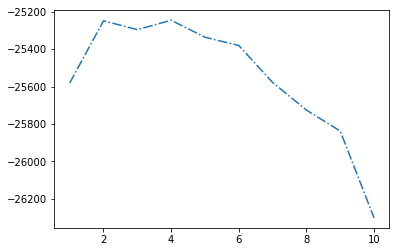

In [10]:
# Plot the log likelihood values
plt.plot(idxs,lls,'-.');

### Word classifier

We will now train a different HMM for each word, and the output of the classifier will be the word with higher loglikelihood.

* Divide the instances of each word into train (5) and test (10)
* Train the HMM's and estimate the classification error on the test instances. Print out the confusion matrix.

In [11]:
np.random.seed(0)

# Train a Gaussian HMM for each word
models=[]
for word in words:
    idx = word_idx(labels,word)
    x_train,seqlenght_train,x_test,seqlenght_test = getTrainTestSets(features,idx)
    ll,model = fitGaussianHMM(x_train,seqlenght_train,x_test,seqlenght_test,4)
    models=np.append(models,model)

# Log likelihood matrix
lls=np.zeros((105,7)) 

# Get log likelihood for every word in data set
for i in range(7):
    m=models[i]
    for j in range(105):            
        x=features[j].T
        lls[j,i]=np.round(m.score(x))


# Get label with highest log likelihood
def getlabels(lls,words):
    n,k = lls.shape
    label_pred = []
    j=1
    for i in range(n):
        aux=np.nonzero(lls[i,:]==lls[i,:].max())
        label_pred.append(words[int(aux[0][0])])
        
    label_pred = np.asarray(label_pred)
    return label_pred

label_pred = getlabels(lls,words)

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:468: R

In [13]:
# Classification report
print('Classification report:')
print(classification_report(labels, label_pred))

# Confusion matrix
cm = confusion_matrix(labels,label_pred)
print('\nConfusion matrix:\n',cm)

# Classification error
missed = (label_pred != labels)
print('\nClassification error: %.2f percent' % (100 * (np.mean(missed))))

Classification report:
             precision    recall  f1-score   support

      apple       1.00      1.00      1.00        15
     banana       1.00      1.00      1.00        15
       kiwi       1.00      0.93      0.97        15
       lime       1.00      0.80      0.89        15
     orange       1.00      1.00      1.00        15
      peach       0.94      1.00      0.97        15
  pineapple       0.83      1.00      0.91        15

avg / total       0.97      0.96      0.96       105


Confusion matrix:
 [[15  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0]
 [ 0  0 14  0  0  1  0]
 [ 0  0  0 12  0  0  3]
 [ 0  0  0  0 15  0  0]
 [ 0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0 15]]

Classification error: 3.81 percent


Use LOO onto the train instances to select the number of hidden states. Try values from 1 to 5.

In [14]:
from sklearn.model_selection import KFold

# Concatenate the elements of X
def concatenateFeatureMatrix(X):
    seqlenght = np.empty(len(X),dtype=np.int)
    sequences = np.empty([0,6])
    for i in range(X.shape[0]):
        sequences = np.append(sequences,np.transpose(X[i]),axis=0)
        seqlenght[i] = int(X[i].shape[1])
    return sequences,seqlenght

# Use LOO to get log likelihood for a certain number of hidden states
def getLLForHiddenState(X,hidden_states):
    models=[]
    ll=[] 
    kf = KFold(n_splits=15)
    for train_index, test_index in kf.split(X):
        sequences,seqlenght = concatenateFeatureMatrix(X[train_index]) # Concatenate the elements in the train set
        model = GaussianHMM(n_components=hidden_states,covariance_type='full',n_iter=100).fit(
        sequences,lengths=seqlenght) # Fit the Gaussian HMM for a given number of hidden states
        ll=np.append(ll,model.score(X[test_index][0].T))
    return ll.mean() # Get the average log likelihood value

In [15]:
# Get the optimal number of hidden states for each HMM
for word in words:
    idx=word_idx(labels,word)
    X=features[idx]
    lls=[]
    hidden_states=[1,2,3,4,5]
    for hs in hidden_states:
        ll=getLLForHiddenState(X,hs)
        lls.append(ll)
    opt_hs=hidden_states[np.argmax(lls)]
    print('The optimal number of hidden states for {} is {}'.format(word,opt_hs))

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:468: R

The optimal number of hidden states for banana is 5
The optimal number of hidden states for kiwi is 4
The optimal number of hidden states for peach is 5
The optimal number of hidden states for apple is 5
The optimal number of hidden states for pineapple is 4
The optimal number of hidden states for lime is 5


/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


The optimal number of hidden states for orange is 5
